# Imports

In [2]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install albumentations

  Using cached albumentations-1.4.3-py3-none-any.whl.metadata (37 kB)
Using cached albumentations-1.4.3-py3-none-any.whl (137 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import cv2
import shutil
import os
import zipfile
import gzip
import random
from pprint import pprint

from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
import torchvision.models as models

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt
import random

## Unzipping the dataset

### DONT USE UNTIL PORTING A NEW DATASET

In [ ]:
directory_to_remove = 'data_cloud_final/data_cloud_final/imgs/train_set'

try:
    shutil.rmtree(directory_to_remove)
    print(f"Directory '{directory_to_remove}' successfully removed.")
except OSError as e:
    print(f"Error: {directory_to_remove} : {e.strerror}")

In [ ]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Change the working directory to the parent directory
os.chdir('..')

# Verify the change
new_directory = os.getcwd()
print("New working directory:", new_directory)

In [33]:
# Path to your ZIP file
zip_file = "data_cloud_final.zip"
destination_folder = "data_cloud_final"

try:
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

        # Unzip the contents of the gzip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)

        print("Files unzipped successfully.")
    else:
        print("Destination folder already exists. Skipping extraction.")
except Exception as e:
    print(f"Error: {e}")

Files unzipped successfully.


# Original Data check

In [34]:
imgs = r'data_cloud_final/data_cloud_final/imgs/train'

In [51]:
# Number of images to pick from each subfolder
num_images_to_train_test = 100

# Get the list of subfolders in the main directory
subfolders = [f.path for f in os.scandir(imgs) if f.is_dir()]
print(subfolders)

['data_cloud_final/data_cloud_final/imgs/train/YES', 'data_cloud_final/data_cloud_final/imgs/train/NO', 'data_cloud_final/data_cloud_final/imgs/train/.ipynb_checkpoints']


In [52]:
yes_subfolder = subfolders[0]
yes_subfolder

'data_cloud_final/data_cloud_final/imgs/train/YES'

In [53]:
yes_subfolder_subfolder = [f.path for f in os.scandir(yes_subfolder) if f.is_dir()]
yes_subfolder_subfolder

['data_cloud_final/data_cloud_final/imgs/train/YES/c3',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c1',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c6',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c7',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c4',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c5',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c2',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c8',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c9']

In [54]:
no_subfolder=subfolders[1]
no_subfolder

'data_cloud_final/data_cloud_final/imgs/train/NO'

In [55]:
no_subfolder_subfolder = [f.path for f in os.scandir(no_subfolder) if f.is_dir()]
no_subfolder_subfolder

['data_cloud_final/data_cloud_final/imgs/train/NO/c0']

In [56]:
images_yes = []

for subfolder in yes_subfolder_subfolder:
    files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith('.jpg')]
    images_yes.extend(files)

In [57]:
len(images_yes)

2259

In [58]:
image_no=[]

for subfolder in no_subfolder_subfolder:
    files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith('.jpg')]
    image_no.extend(files)

In [59]:
len(image_no)

2259

# Training set creation {Balanced}

In [60]:
def count_jpg_files_in_directory(path):
    # Initialize a counter
    jpg_count = 0

    # Walk through the directory and count JPG files
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith('.jpg'):
                jpg_count += 1

    return jpg_count

### NO

In [61]:
# Pick the specified number of images
selected_images_train = random.sample(image_no, num_images_to_train_test)

# make destination directory
destination_dir_train = r'training_set/'

# Remove existing directories and create new ones
shutil.rmtree(destination_dir_train, ignore_errors=True)
os.makedirs(destination_dir_train)

for image_path in selected_images_train:
    # Create the destination subfolder structure in the destination directory
    relative_path = os.path.relpath(image_path, imgs)
    relative_path = relative_path.replace("/c0","")
    destination_path = os.path.join(destination_dir_train, relative_path)
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    # Copy the image
    shutil.copyfile(image_path, destination_path)

print(f"{num_images_to_train_test} images from each subfolder have been copied to {destination_dir_train}.")

100 images from each subfolder have been copied to training_set/.


In [63]:
path = r'training_set/NO'
file_count = count_jpg_files_in_directory(path)
print("Number of NO images in directory:", file_count)

Number of NO images in directory: 100


### YES

In [66]:
for folder in yes_subfolder_subfolder:

    images = [f.path for f in os.scandir(folder) if f.is_file() and f.name.endswith(('.jpg'))]
    # print(images[:3])
    # Pick the specified number of images
    selected_images_train = random.sample(images, int(num_images_to_train_test / 9))

    # make destination directory
    destination_dir_train = r'training_set/'

    os.makedirs(destination_dir_train,exist_ok=True)

    for image_path in selected_images_train:
        # Create the destination subfolder structure in the destination directory
        relative_path = os.path.relpath(image_path, imgs)

         # Define the list of 'cX' values to replace
        c_values_to_replace = [f'/c{i}' for i in range(10)]

        # Remove 'cX' values from the relative_path
        for c_value in c_values_to_replace:
            relative_path = relative_path.replace(c_value, '')

        destination_path = os.path.join(destination_dir_train, relative_path)
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        # Copy the image
        shutil.copyfile(image_path, destination_path)

    print(f"{int(num_images_to_train_test / 9)} images from  {folder} have been copied to {destination_dir_train}.")

11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c3 have been copied to training_set/.
11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c1 have been copied to training_set/.
11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c6 have been copied to training_set/.
11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c7 have been copied to training_set/.
11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c4 have been copied to training_set/.
11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c5 have been copied to training_set/.
11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c2 have been copied to training_set/.
11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c8 have been copied to training_set/.
11 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c9 have been copied to training_set/.


In [67]:
path = r'training_set/YES'
file_count = count_jpg_files_in_directory(path)
print("Number of YES images in directory:", file_count)

Number of YES images in directory: 99


# Loading Images

In [68]:
# Define the directory path
directory = 'training_set/'

# Function to recursively find image files in subfolders
def find_images(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file has an image extension
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_files.append(os.path.join(root, file))
    return image_files

# Find all image files in subfolders
all_image_paths = find_images(directory)

In [69]:
all_image_paths_sorted = sorted(all_image_paths)

In [70]:
len(all_image_paths_sorted)

199

# Import CUDA

In [71]:
# Check if GPU is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # Print information about each GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    # Set the default device to the first GPU
    torch.cuda.set_device(torch.device('cuda:0'))
    print("\nDefault device set to GPU.")

    # Check if PyTorch is currently using GPU
    current_device = torch.cuda.current_device()
    print(f"PyTorch is currently using GPU: {torch.cuda.get_device_name(current_device)}")
else:
    print("No GPU available. PyTorch is using CPU.")

Number of available GPUs: 1
GPU 0: Tesla T4

Default device set to GPU.
PyTorch is currently using GPU: Tesla T4


In [72]:
train_x = all_image_paths_sorted
train_y = [path.split('/')[-2] for path in all_image_paths_sorted]

In [73]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=5, stratify=train_y)

In [157]:
transforms = A.Compose(
    [
        A.Resize(height=300, width=300), # Resize to 300x300"
        A.ToFloat(),
        ToTensorV2(),
    ]
)

In [158]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
encoded_labels_train = label_encoder.fit_transform(train_y)
tensor_encoded_labels_train = torch.tensor(encoded_labels_train)
pprint(tensor_encoded_labels_train)


# Fit label encoder and transform labels
encoded_labels_test = label_encoder.fit_transform(test_y)
tensor_encoded_labels_test = torch.tensor(encoded_labels_test)
pprint(tensor_encoded_labels_test)

tensor([3, 7, 0,  ..., 0, 0, 6])
tensor([0, 0, 9, 0, 0, 0, 0, 1, 3, 6, 1, 0, 0, 0, 9, 3, 0, 0, 3, 2, 0, 0, 1, 0,
        3, 3, 8, 4, 8, 6, 0, 4, 0, 4, 3, 0, 1, 9, 0, 0, 0, 0, 0, 0, 1, 0, 4, 8,
        6, 0, 0, 0, 0, 9, 0, 5, 2, 1, 1, 0, 8, 0, 0, 0, 0, 9, 0, 0, 6, 5, 0, 5,
        6, 0, 0, 5, 8, 3, 5, 0, 0, 0, 0, 7, 7, 5, 1, 2, 0, 3, 9, 1, 7, 8, 3, 6,
        8, 5, 0, 8, 5, 0, 0, 0, 5, 9, 3, 1, 4, 0, 0, 0, 0, 0, 0, 0, 1, 7, 6, 0,
        4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 0, 5, 8, 1, 3, 1, 7, 5, 0, 0, 6,
        0, 0, 0, 7, 9, 8, 0, 0, 0, 8, 0, 5, 7, 0, 4, 0, 0, 4, 7, 0, 2, 5, 3, 0,
        0, 0, 7, 0, 8, 4, 1, 4, 6, 0, 8, 4, 2, 2, 3, 0, 2, 0, 3, 0, 2, 0, 0, 3,
        0, 0, 0, 0, 0, 6, 1, 0, 2, 0, 9, 7, 0, 0, 0, 0, 6, 1, 0, 0, 6, 0, 8, 5,
        0, 0, 5, 4, 0, 0, 0, 0, 8, 6, 0, 3, 0, 0, 0, 0, 3, 0, 0, 9, 0, 0, 3, 0,
        1, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 4, 5, 9, 0, 3, 9, 0, 4, 0, 1, 3, 5, 0,
        0, 6, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 4, 0, 8, 2, 0, 3, 5, 0, 3,
       

In [18]:
class image_Dataset(Dataset):
    def __init__(self, image_paths, tensor_encoded_labels, transform=None):
        """
        Args:
            image_paths (list): List of file paths to images.
            labels (list): List of labels corresponding to the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_paths = image_paths
        self.labels = tensor_encoded_labels
        self.transform = transform


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None and callable(self.transform):
            image = self.transform(image=image)["image"]

        # Convert label to PyTorch tensor
        label = self.labels[idx]

        return image, label

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

## dataset check

In [187]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = image_Dataset(train_x,tensor_encoded_labels_train,transforms)
test_dataset = image_Dataset(test_x,tensor_encoded_labels_test,transforms)

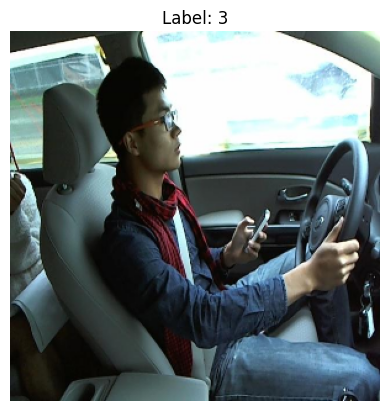

The shape of tensor for 50th image in train dataset:  torch.Size([3, 300, 300])
The label for 50th image in train dataset:  tensor(3)


In [188]:
for i in range(1):
  image, label = train_dataset[i]
  image = TF.to_pil_image(image)  # Convert the tensor to a PIL Image
  image = np.array(image)
  plt.imshow(image)
  plt.title(f"Label: {label}")
  plt.axis('off')  # Turn off axis
  plt.show()

print('The shape of tensor for 50th image in train dataset: ',train_dataset[0][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[0][1])

In [189]:
#######################################################
#                  load Dataset
#######################################################

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Different Model Architectures

## Architecture-1

In [2]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ImageClassifier, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(3))
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*33*33, out_features=num_classes))

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)
        return x

NameError: name 'torch' is not defined

In [ ]:
model_test = ImageClassifier()
model_test.cuda()

In [202]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_test.parameters(), lr=0.001, momentum=0.75)
num_epochs = 20
model_test.train().cuda()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [199]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model_test(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### V0

In [ ]:
modelV0 = ImageClassifier()
modelV0.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV0.parameters(), lr=0.001, momentum=0.75)
num_epochs = 20
modelV0.train()

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV0(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

In [ ]:
torch.save(modelV0, 'modelV0.pth')

### V1

In [ ]:
modelV1 = ImageClassifier()
modelV1 = modelV1.to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV1.parameters(), lr=0.005, momentum=0.50)
num_epochs = 20
modelV1.train()

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

In [ ]:
torch.save(modelV1, 'modelV1.pth')

## Architecture-2

In [179]:
class ImageClassifier_V2(nn.Module):
    def __init__(self, num_classes=2):
        super(ImageClassifier_V2, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2),  # Adjusted kernel_size
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=3, stride=1))  # Adjusted kernel_size and stride

        # Calculate the input size for the linear layer based on the output of conv_layer_3
        self.classifier_input_size = 512*34*34  # Adjusted based on the spatial dimensions

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.classifier_input_size, out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        #print("Shape after conv_layer_1:", x.shape)

        x = self.conv_layer_2(x)

        #print("Shape after conv_layer_2:", x.shape)
        x = self.conv_layer_3(x)

        #print("Shape after conv_layer_3:", x.shape)


        x = self.classifier(x)
        return x

### V2

In [ ]:
modelV2 = ImageClassifier_V2()
modelV2 = modelV2.to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV2.parameters(), lr=0.005, momentum=0.03)
num_epochs = 20
modelV2.train()

In [ ]:
# Assuming you have a DataLoader named 'train_loader'
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

### V3

In [ ]:
modelV3 = ImageClassifier_V2()
modelV3 = modelV3.to('cuda')
modelV3.train()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelV3.parameters(), lr=0.0001)
num_epochs = 20

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels  = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV3(inputs)
        loss1 = criterion(outputs, labels)
        loss1.backward()
        optimizer.step()
        total_loss += (loss1.item())*inputs.size(0)


    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

In [ ]:
torch.save(modelV3, 'modelV3.pth')

### V4

In [ ]:
modelV4 = ImageClassifier_V2()
modelV4 = modelV4.to('cuda')
modelV4.train()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelV4.parameters(), lr=0.001, momentum=0.75)
num_epochs = 20

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels  = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV4(inputs)
        loss1 = criterion(outputs, labels)
        loss1.backward()
        optimizer.step()
        total_loss += (loss1.item())*inputs.size(0)


    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

In [ ]:
torch.save(modelV4, 'modelV4.pth')

# Basic Evaluation

In [169]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
            accuracy = float(num_correct) / float(num_samples) * 100

    return accuracy , num_correct , num_samples

### V0

In [185]:
modelV0 = torch.load("modelV0.pth").to('cuda')

train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV0)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV0)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 55.37%, Correct: 2001, Total: 3614
Test Set Accuracy: 55.20%, Correct: 499, Total: 904


### V1

In [ ]:
modelV1 = torch.load("modelV1.pth").to('cuda')

train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

### V2

In [ ]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV2)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV2)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

### V3

In [ ]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV3)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV3)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

### V4

In [ ]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV4)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV4)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

# CROSS VALIDATION TEST

In [ ]:


def train(model, device, train_loader, optimizer,criterion, epoch):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels  = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += (loss.item())*inputs.size(0)


        average_loss = total_loss / len(train_loader.sampler)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

In [ ]:


yes_image_paths = [path for path in all_image_paths_sorted if 'YES' in path]
no_image_paths = [path for path in all_image_paths_sorted if 'NO' in path]

# Randomly select 50 YES and 50 NO image paths
selected_yes_image_paths = random.sample(yes_image_paths, 50)
selected_no_image_paths = random.sample(no_image_paths, 50)

# Create validation set containing selected image paths
validation_set = selected_yes_image_paths + selected_no_image_paths

In [ ]:
validation_X = validation_set

In [ ]:
validation_Y = [path.split('/')[-2] for path in validation_X]

In [ ]:
encoded_labels_validation_dataset = label_encoder.fit_transform(validation_Y)
tensor_encoded_labels_validation_dataset = torch.tensor(encoded_labels_validation_dataset)
pprint(tensor_encoded_labels_validation_dataset)

In [ ]:
validation_dataset = image_Dataset(validation_X,tensor_encoded_labels_validation_dataset,transforms)

In [ ]:
validation_dataset = list(zip(validation_X, validation_Y))

In [ ]:
validation_dataset[0]

In [ ]:
train_set = [path for path in all_image_paths_sorted if path not in validation_set]

In [ ]:
X = train_set
Y = [path.split('/')[-2] for path in train_set]

In [ ]:
dataset = list(zip(X, Y))

In [ ]:
dataset[0]

In [ ]:
encoded_labels_Kfold_dataset = label_encoder.fit_transform(Y)
tensor_encoded_labels_Kfold_dataset = torch.tensor(encoded_labels_Kfold_dataset)
pprint(tensor_encoded_labels_Kfold_dataset)

In [ ]:
#######################################################
#                  Create Dataset
#######################################################

dataset_dataset = image_Dataset(X,tensor_encoded_labels_Kfold_dataset,transforms)

In [ ]:
# Define the number of folds and batch size
k_folds = 10
batch_size = 64

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

In [ ]:
train_accuracies = []
test_accuracies = []

In [ ]:
for fold, (train_idx, test_idx) in enumerate(kf.split(dataset_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")
    

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=dataset_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = DataLoader(
        dataset=dataset_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model = ImageClassifier_V2().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    # Train the model on the current fold
    train(model, device, train_loader, optimizer,criterion, epoch)

    # Evaluate the model on the test set
    model.eval()
 
    with torch.no_grad():
        train_accuracy, train_correct, train_total = check_accuracy(train_loader, model)
        test_accuracy, test_correct, test_total = check_accuracy(test_loader, model)

        print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
        print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")
        
        # Append accuracies to lists
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

In [ ]:
# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)

print(f"Average Train Set Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Set Accuracy: {avg_test_accuracy:.2f}%")

# Test on validation Set Model V3

In [ ]:
validation_loader = DataLoader(dataset=validation_dataset, batch_size=64)

### modelV3 last in kfold

In [ ]:
validation_accuracy, validation_correct, validation_total = check_accuracy(validation_loader, model)

print(f"Validation Set Accuracy: {validation_accuracy:.2f}%, Correct: {validation_correct}, Total: {validation_total}")


### modelV3

In [ ]:
validation_accuracy, validation_correct, validation_total = check_accuracy(validation_loader, modelV3)

print(f"Validation Set Accuracy: {validation_accuracy:.2f}%, Correct: {validation_correct}, Total: {validation_total}")


# Save all in google bucket

In [ ]:
!gsutil cp * gs://igneous-core-416413-eu-notebooks